In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
!!pip install category_encoders
import category_encoders as ce
from statsmodels.formula.api import ols      # For n-way ANOVA
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline 

import sweetviz as sv # for sweet viz eda

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn import metrics

### Problem 1: Linear Regression

#### You are hired by a company Gem Stones co ltd, which is a cubic zirconia manufacturer. You are provided with the dataset containing the prices and other attributes of almost 27,000 cubic zirconia (which is an inexpensive diamond alternative with many of the same qualities as a diamond). The company is earning different profits on different prize slots. You have to help the company in predicting the price for the stone on the bases of the details given in the dataset so it can distinguish between higher profitable stones and lower profitable stones so as to have better profit share. Also, provide them with the best 5 attributes that are most important.

#### 1.1. Read the data and do exploratory data analysis. Describe the data briefly. (Check the null values, Data types, shape, EDA). Perform Univariate and Bivariate Analysis.

In [2]:
Df = pd.read_csv('cubic_zirconia.csv')
Df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [3]:
Df.describe()

,Unnamed: 0,carat,depth,table,x,y,z,price
count,26967.000000,26967.000000,26270.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,13484.000000,0.798375,61.745147,57.456080,5.729854,5.733569,3.538057,3939.518115
std,7784.846691,0.477745,1.412860,2.232068,1.128516,1.166058,0.720624,4024.864666
min,1.000000,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,6742.500000,0.400000,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,13484.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2375.000000
75%,20225.500000,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5360.000000
max,26967.000000,4.500000,73.600000,79.000000,10.230000,58.900000,31.800000,18818.000000


In [4]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  26967 non-null  int64  
 1   carat       26967 non-null  float64
 2   cut         26967 non-null  object 
 3   color       26967 non-null  object 
 4   clarity     26967 non-null  object 
 5   depth       26270 non-null  float64
 6   table       26967 non-null  float64
 7   x           26967 non-null  float64
 8   y           26967 non-null  float64
 9   z           26967 non-null  float64
 10  price       26967 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


In [5]:
print("Number of Duplicates ",Df.duplicated().sum())

Number of Duplicates  0


In [6]:
Df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
(Df == 0).all()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
x          False
y          False
z          False
price      False
dtype: bool

In [8]:
Df.isnull().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

In [9]:
for column in Df.columns:
    if Df[column].dtype == 'object':
        print(column.upper(),': ',Df[column].nunique())
        print(Df[column].value_counts().sort_values())
        print('\n')

CUT :  5
Fair           781
Good          2441
Very Good     6030
Premium       6899
Ideal        10816
Name: cut, dtype: int64


COLOR :  7
J    1443
I    2771
D    3344
H    4102
F    4729
E    4917
G    5661
Name: color, dtype: int64


CLARITY :  8
I1       365
IF       894
VVS1    1839
VVS2    2531
VS1     4093
SI2     4575
VS2     6099
SI1     6571
Name: clarity, dtype: int64




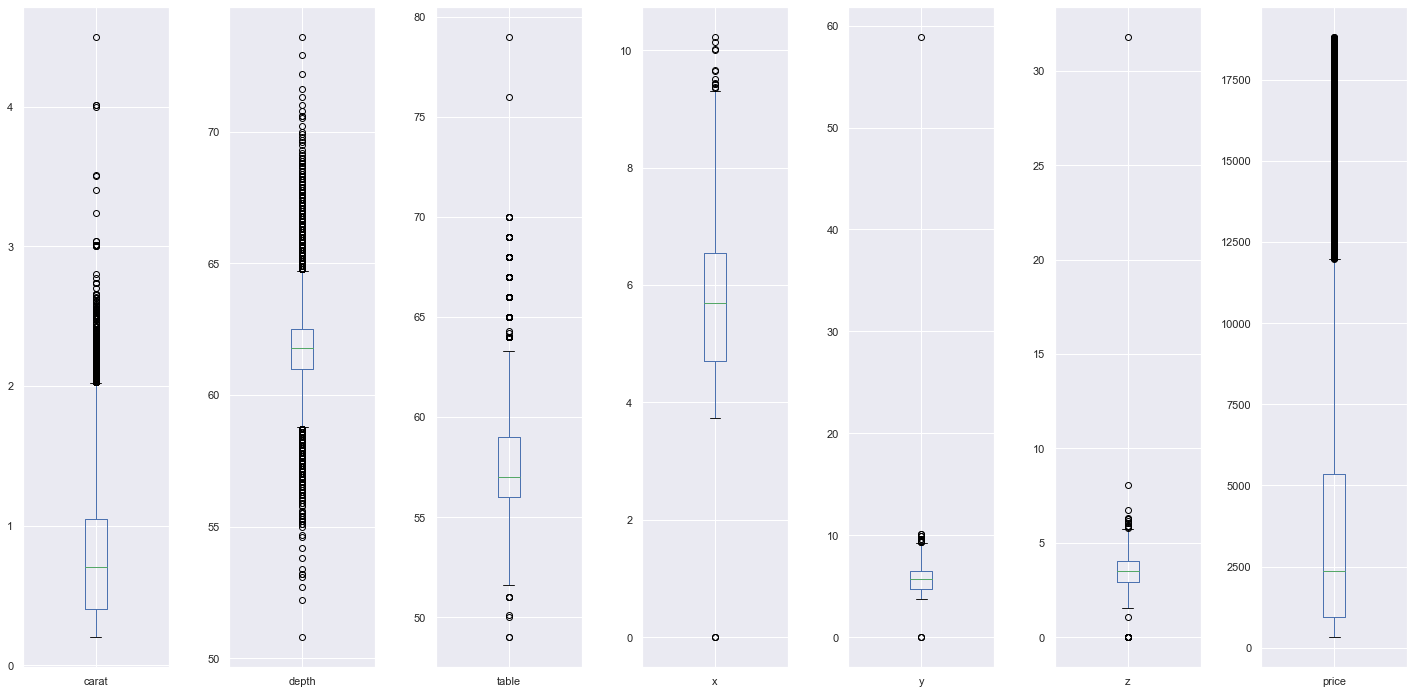

In [10]:
Df.plot(kind='box',subplots=True,figsize=(20,10))
plt.tight_layout(pad=2.0)

In [11]:
from scipy import stats

numeric_cols = Df.select_dtypes(include=[np.number]).columns
numeric_cols=numeric_cols.delete(-1) #Removed the target column price 


z=np.abs(stats.zscore(Df[numeric_cols]))
listin= np.where(z>3)


outlier = list((int(j) for i in listin for j in i)) 
print("the number of outliers are ", len(outlier) )

the number of outliers are  892


In [12]:
print("replace outliers")

def outlier(x):
    # taking 5,25,75 percentile of column
    q5= np.percentile(x,5)
    q25=np.percentile(x,25)
    q75=np.percentile(x,75)
    dt=np.percentile(x,95)
    #calculationg IQR range
    IQR=q75-q25
    #Calculating minimum threshold
    lower_bound=q25-(1.5*IQR)
    upper_bound=q75+(1.5*IQR)
    #Calculating maximum threshold
    return x.apply(lambda y: dt if y > upper_bound else y).apply(lambda y: q5 if y < lower_bound else y)


Df[numeric_cols]=Df[numeric_cols].apply(outlier)
Df.describe()

replace outliers


,carat,depth,table,x,y,z,price
count,26967.000000,26270.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,0.785860,61.745147,57.407702,5.729438,5.731334,3.537316,3939.518115
std,0.444042,1.412860,2.090151,1.124638,1.116593,0.694826,4024.864666
min,0.200000,50.800000,51.600000,3.730000,3.710000,1.530000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2375.000000
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5360.000000
max,2.020000,73.600000,63.300000,9.300000,9.260000,5.750000,18818.000000


carat       AxesSubplot(0.125,0.125;0.0945122x0.755)
depth    AxesSubplot(0.238415,0.125;0.0945122x0.755)
table    AxesSubplot(0.351829,0.125;0.0945122x0.755)
x        AxesSubplot(0.465244,0.125;0.0945122x0.755)
y        AxesSubplot(0.578659,0.125;0.0945122x0.755)
z        AxesSubplot(0.692073,0.125;0.0945122x0.755)
price    AxesSubplot(0.805488,0.125;0.0945122x0.755)
dtype: object

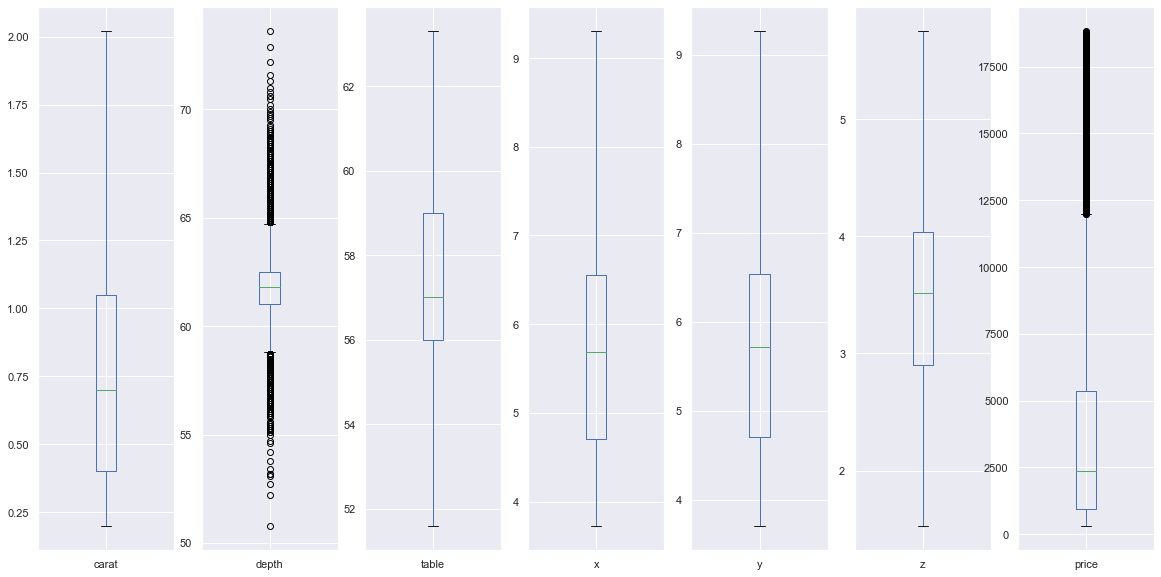

In [13]:
Df.plot(kind='box',subplots=True,figsize=(20,10))

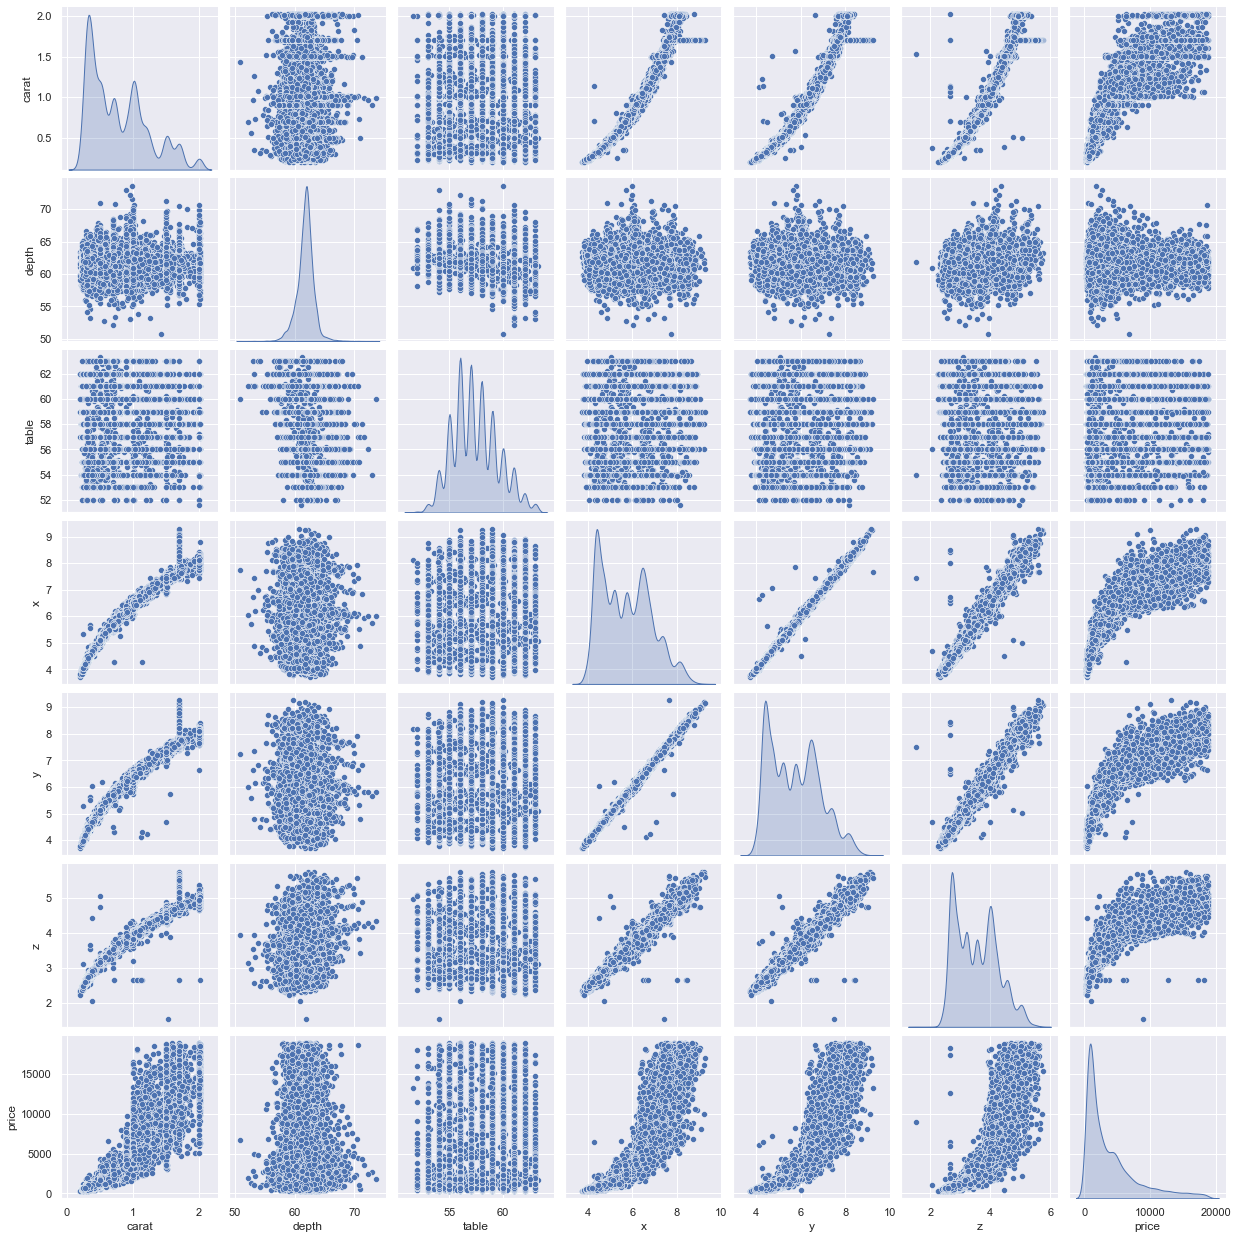

In [14]:
sns.pairplot(Df, diag_kind='kde')

In [15]:
zirconia= sv.analyze(Df,target_feat='price')

In [16]:
zirconiapriciereport=zirconia.show_html('zirconiapriciereport.html')
zirconiapriciereport

Report zirconiapriciereport.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### 1.2 Impute null values if present, also check for the values which are equal to zero. Do they have any meaning or do we need to change them or drop them? Do you think scaling is necessary in this case?

In [17]:
(Df == 0).all()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
x          False
y          False
z          False
price      False
dtype: bool

In [18]:
Df.isnull().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

In [19]:
from sklearn.impute import SimpleImputer
SI = SimpleImputer(strategy='most_frequent')
impute_df = pd.DataFrame(SI.fit_transform(Df),columns=Df.columns)
impute_df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.3,Ideal,E,SI1,62.1,58,4.27,4.29,2.66,499
1,0.33,Premium,G,IF,60.8,58,4.42,4.46,2.7,984
2,0.9,Very Good,E,VVS2,62.2,60,6.04,6.12,3.78,6289
3,0.42,Ideal,F,VS1,61.6,56,4.82,4.8,2.96,1082
4,0.31,Ideal,F,VVS1,60.4,59,4.35,4.43,2.65,779


In [20]:
impute_df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [21]:
impute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   carat    26967 non-null  object
 1   cut      26967 non-null  object
 2   color    26967 non-null  object
 3   clarity  26967 non-null  object
 4   depth    26967 non-null  object
 5   table    26967 non-null  object
 6   x        26967 non-null  object
 7   y        26967 non-null  object
 8   z        26967 non-null  object
 9   price    26967 non-null  object
dtypes: object(10)
memory usage: 2.1+ MB


In [22]:
Df.describe()

,carat,depth,table,x,y,z,price
count,26967.000000,26270.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,0.785860,61.745147,57.407702,5.729438,5.731334,3.537316,3939.518115
std,0.444042,1.412860,2.090151,1.124638,1.116593,0.694826,4024.864666
min,0.200000,50.800000,51.600000,3.730000,3.710000,1.530000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2375.000000
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5360.000000
max,2.020000,73.600000,63.300000,9.300000,9.260000,5.750000,18818.000000


#### 1.3 Encode the data (having string values) for Modelling. Data Split: Split the data into train and test (70:30). Apply Linear regression. Performance Metrics: Check the performance of Predictions on Train and Test sets using Rsquare, RMSE.

In [23]:
#df[['carat','depth','table','x','y','z','price']] =df[['carat','depth','table','x','y','z','price']].astype('float64')
encodercut= ce.OrdinalEncoder(cols=['cut'],return_df=True,
                           mapping=[{'col':'cut','mapping':{'Fair':1,'Good':2,'Very Good':3,'Premium':4,'Ideal':5}}])  

df= encodercut.fit_transform(impute_df)
df.head()

C:\Users\pavan\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.3,5,E,SI1,62.1,58,4.27,4.29,2.66,499
1,0.33,4,G,IF,60.8,58,4.42,4.46,2.7,984
2,0.9,3,E,VVS2,62.2,60,6.04,6.12,3.78,6289
3,0.42,5,F,VS1,61.6,56,4.82,4.8,2.96,1082
4,0.31,5,F,VVS1,60.4,59,4.35,4.43,2.65,779


In [24]:
encodercolor= ce.OrdinalEncoder(cols=['color'],return_df=True,
                           mapping=[{'col':'color','mapping':{'D':7,'E':6,'F':5,'G':4,'H':3,'I':2,'J':1}}])  

df=encodercolor.fit_transform(df)
df.head()

C:\Users\pavan\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.3,5,6,SI1,62.1,58,4.27,4.29,2.66,499
1,0.33,4,4,IF,60.8,58,4.42,4.46,2.7,984
2,0.9,3,6,VVS2,62.2,60,6.04,6.12,3.78,6289
3,0.42,5,5,VS1,61.6,56,4.82,4.8,2.96,1082
4,0.31,5,5,VVS1,60.4,59,4.35,4.43,2.65,779


In [25]:
encoderclarity=ce.OrdinalEncoder(cols=['clarity'],return_df=True,
                           mapping=[{'col':'clarity','mapping':{'FL':11,'IF':10,'VVS1':9,'VVS2':8,'VS1':7,'VS2':6,'SI1':5,'SI2':4,'I1':3,'I2':2,'I3':1}}])   

df=encoderclarity.fit_transform(df)
df.head()

C:\Users\pavan\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.3,5,6,5,62.1,58,4.27,4.29,2.66,499
1,0.33,4,4,10,60.8,58,4.42,4.46,2.7,984
2,0.9,3,6,8,62.2,60,6.04,6.12,3.78,6289
3,0.42,5,5,7,61.6,56,4.82,4.8,2.96,1082
4,0.31,5,5,9,60.4,59,4.35,4.43,2.65,779


In [26]:
df[['carat','depth','table','x','y','z','price']] =df[['carat','depth','table','x','y','z','price']].astype('float64')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    26967 non-null  float64
 1   cut      26967 non-null  int32  
 2   color    26967 non-null  int32  
 3   clarity  26967 non-null  int32  
 4   depth    26967 non-null  float64
 5   table    26967 non-null  float64
 6   x        26967 non-null  float64
 7   y        26967 non-null  float64
 8   z        26967 non-null  float64
 9   price    26967 non-null  float64
dtypes: float64(7), int32(3)
memory usage: 1.7 MB


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,26967.0,0.785860,0.444042,0.20,0.40,0.70,1.05,2.02
cut,26967.0,3.909556,1.113229,1.00,3.00,4.00,5.00,5.00
color,26967.0,4.393889,1.705992,1.00,3.00,4.00,6.00,7.00
clarity,26967.0,6.053102,1.647042,3.00,5.00,6.00,7.00,10.00
depth,26967.0,61.751734,1.395068,50.80,61.10,61.90,62.50,73.60
table,26967.0,57.407702,2.090151,51.60,56.00,57.00,59.00,63.30
x,26967.0,5.729438,1.124638,3.73,4.71,5.69,6.55,9.30
y,26967.0,5.731334,1.116593,3.71,4.71,5.71,6.54,9.26
z,26967.0,3.537316,0.694826,1.53,2.90,3.52,4.04,5.75
price,26967.0,3939.518115,4024.864666,326.00,945.00,2375.00,5360.00,18818.00


In [29]:
X = df.drop('price', axis=1)
y = df[['price']]

print(X.head())
print(y.head())

   carat  cut  color  clarity  depth  table     x     y     z
0   0.30    5      6        5   62.1   58.0  4.27  4.29  2.66
1   0.33    4      4       10   60.8   58.0  4.42  4.46  2.70
2   0.90    3      6        8   62.2   60.0  6.04  6.12  3.78
3   0.42    5      5        7   61.6   56.0  4.82  4.80  2.96
4   0.31    5      5        9   60.4   59.0  4.35  4.43  2.65
    price
0   499.0
1   984.0
2  6289.0
3  1082.0
4   779.0


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)
print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_test.head())

       carat  cut  color  clarity  depth  table     x     y     z
11687   0.41    5      2        8   62.3   56.0  4.77  4.73  2.96
9728    1.71    5      1        5   62.8   57.0  7.58  7.55  4.75
1936    0.33    2      5        5   61.8   62.0  4.40  4.45  2.74
26220   0.70    3      3        5   62.8   57.0  5.61  5.66  3.54
18445   0.70    5      7        4   62.1   56.0  5.67  5.71  3.53
       carat  cut  color  clarity  depth  table     x     y     z
18031   2.01    1      2        4   66.5   61.0  7.81  7.75  5.17
26051   1.51    4      5        5   62.2   59.0  7.34  7.30  4.55
16279   0.50    3      3        5   60.9   61.0  5.06  5.15  3.11
16466   0.31    5      6        7   62.0   56.0  4.39  4.44  2.66
19837   1.20    3      3        7   62.0   57.0  6.77  6.81  4.21
        price
11687  1061.0
9728   6320.0
1936    536.0
26220  2214.0
18445  2575.0
         price
18031  10671.0
26051  11607.0
16279   1133.0
16466    626.0
19837   6177.0


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)
print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_test.head())

       carat  cut  color  clarity  depth  table     x     y     z
11687   0.41    5      2        8   62.3   56.0  4.77  4.73  2.96
9728    1.71    5      1        5   62.8   57.0  7.58  7.55  4.75
1936    0.33    2      5        5   61.8   62.0  4.40  4.45  2.74
26220   0.70    3      3        5   62.8   57.0  5.61  5.66  3.54
18445   0.70    5      7        4   62.1   56.0  5.67  5.71  3.53
       carat  cut  color  clarity  depth  table     x     y     z
18031   2.01    1      2        4   66.5   61.0  7.81  7.75  5.17
26051   1.51    4      5        5   62.2   59.0  7.34  7.30  4.55
16279   0.50    3      3        5   60.9   61.0  5.06  5.15  3.11
16466   0.31    5      6        7   62.0   56.0  4.39  4.44  2.66
19837   1.20    3      3        7   62.0   57.0  6.77  6.81  4.21
        price
11687  1061.0
9728   6320.0
1936    536.0
26220  2214.0
18445  2575.0
         price
18031  10671.0
26051  11607.0
16279   1133.0
16466    626.0
19837   6177.0


In [32]:
X_train_scaled  = X_train.apply(zscore)
X_test_scaled = X_test.apply(zscore)
y_train_scaled = y_train.apply(zscore)
y_test_scaled = y_test.apply(zscore)

In [33]:
regression_model = LinearRegression()
regression_model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [34]:
for idx, col_name in enumerate(X_train_scaled.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for carat is 1.2810088346596173
The coefficient for cut is 0.044086882558962044
The coefficient for color is 0.12342511078790368
The coefficient for clarity is 0.19166493838032614
The coefficient for depth is -0.003837535458018516
The coefficient for table is -0.0153963991906779
The coefficient for x is -0.53583661151529
The coefficient for y is 0.44065827297784976
The coefficient for z is -0.16422719315423415


In [35]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 3.3625543595224435e-16


In [36]:
# R square on training data
regression_model.score(X_train_scaled,y_train_scaled)

0.888699333687784

In [37]:
# R square on testing data
regression_model.score(X_test_scaled, y_test_scaled)

0.8836528787741355

In [38]:
from sklearn import metrics
predicted_train=regression_model.predict(X_train_scaled)
np.sqrt(metrics.mean_squared_error(y_train_scaled,predicted_train))

0.3336175449706086

In [39]:
#RMSE on Testing data
predicted_test=regression_model.predict(X_test_scaled)
np.sqrt(metrics.mean_squared_error(y_test_scaled,predicted_test))

0.341096938165479

### Problem 2: Logistic Regression and LDA

#### You are hired by a tour and travel agency which deals in selling holiday packages. You are provided details of 872 employees of a company. Among these employees, some opted for the package and some didn't. You have to help the company in predicting whether an employee will opt for the package or not on the basis of the information given in the data set. Also, find out the important factors on the basis of which the company will focus on particular employees to sell their packages.

#### 2.1 Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it. Perform Univariate and Bivariate Analysis. Do exploratory data analysis.

In [40]:
data_df = pd.read_csv("Holiday_Package.csv")
data_df.head()

,Unnamed: 0,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,1,no,48412,30,8,1,1,no
1,2,yes,37207,45,8,0,1,no
2,3,no,58022,46,9,0,0,no
3,4,no,66503,31,11,2,0,no
4,5,no,66734,44,12,0,2,no


In [41]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         872 non-null    int64 
 1   Holliday_Package   872 non-null    object
 2   Salary             872 non-null    int64 
 3   age                872 non-null    int64 
 4   educ               872 non-null    int64 
 5   no_young_children  872 non-null    int64 
 6   no_older_children  872 non-null    int64 
 7   foreign            872 non-null    object
dtypes: int64(6), object(2)
memory usage: 54.6+ KB


In [42]:
data_df.describe()

,Unnamed: 0,Salary,age,educ,no_young_children,no_older_children
count,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000
mean,436.500000,47729.172018,39.955275,9.307339,0.311927,0.982798
std,251.869014,23418.668531,10.551675,3.036259,0.612870,1.086786
min,1.000000,1322.000000,20.000000,1.000000,0.000000,0.000000
25%,218.750000,35324.000000,32.000000,8.000000,0.000000,0.000000
50%,436.500000,41903.500000,39.000000,9.000000,0.000000,1.000000
75%,654.250000,53469.500000,48.000000,12.000000,0.000000,2.000000
max,872.000000,236961.000000,62.000000,21.000000,3.000000,6.000000


In [43]:
data_df.isna().sum()

Unnamed: 0           0
Holliday_Package     0
Salary               0
age                  0
educ                 0
no_young_children    0
no_older_children    0
foreign              0
dtype: int64

In [44]:
duplicates = data_df.duplicated()
print('Number of duplicate rows = %d' % (duplicates.sum()))

Number of duplicate rows = 0


In [45]:
data_df.drop('Unnamed: 0', axis=1, inplace=True)
data_df.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,no,48412,30,8,1,1,no
1,yes,37207,45,8,0,1,no
2,no,58022,46,9,0,0,no
3,no,66503,31,11,2,0,no
4,no,66734,44,12,0,2,no


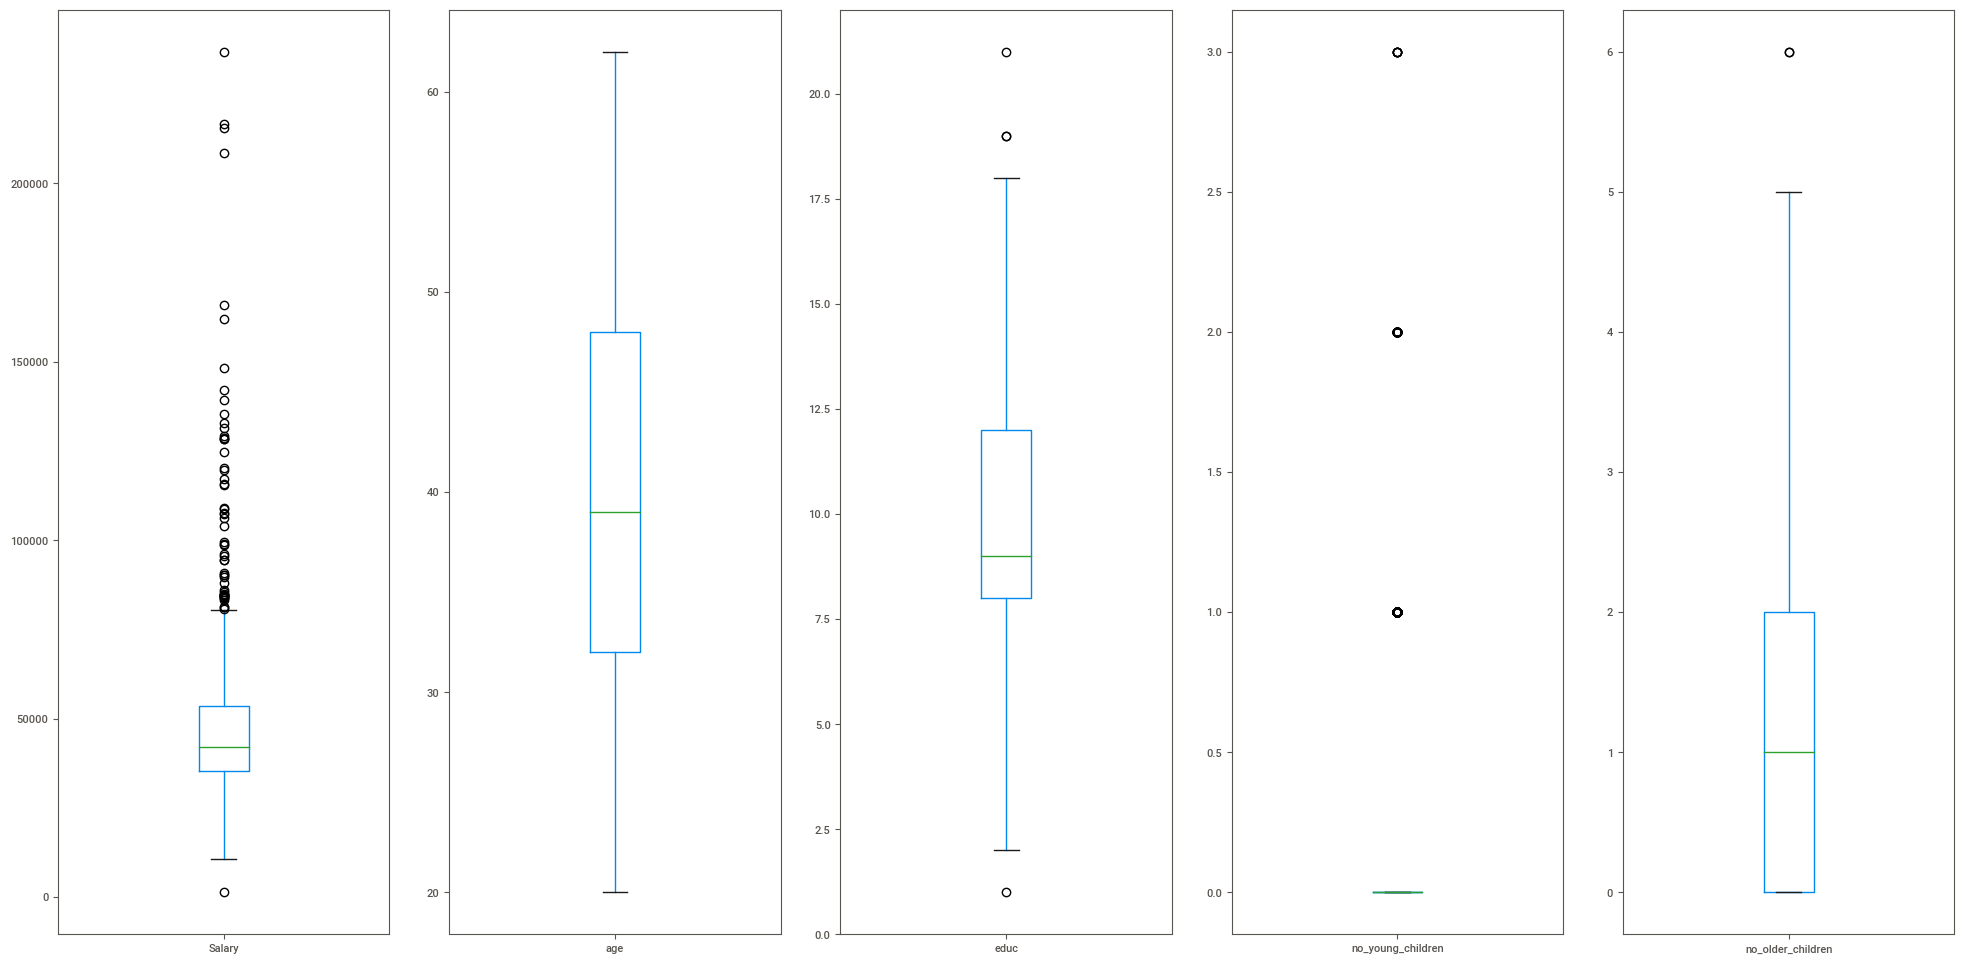

In [46]:
data_df.plot(kind='box',subplots=True,figsize=(20,10))
plt.tight_layout(pad=2.0)

In [47]:
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['Salary', 'age', 'educ', 'no_young_children', 'no_older_children'], dtype='object')

In [48]:
from scipy import stats

z=np.abs(stats.zscore(data_df['Salary']))

listin= np.where(z>3)

outlier = list((int(j) for i in listin for j in i)) 
print("the number of outliers are ", len(outlier) )

the number of outliers are  19


In [49]:
print("remove outliers")

def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range
lower_range, upper_range=remove_outlier(data_df['Salary'])

data_df = data_df.loc[(data_df['Salary'] > lower_range) & (data_df['Salary'] < upper_range)]

remove outliers


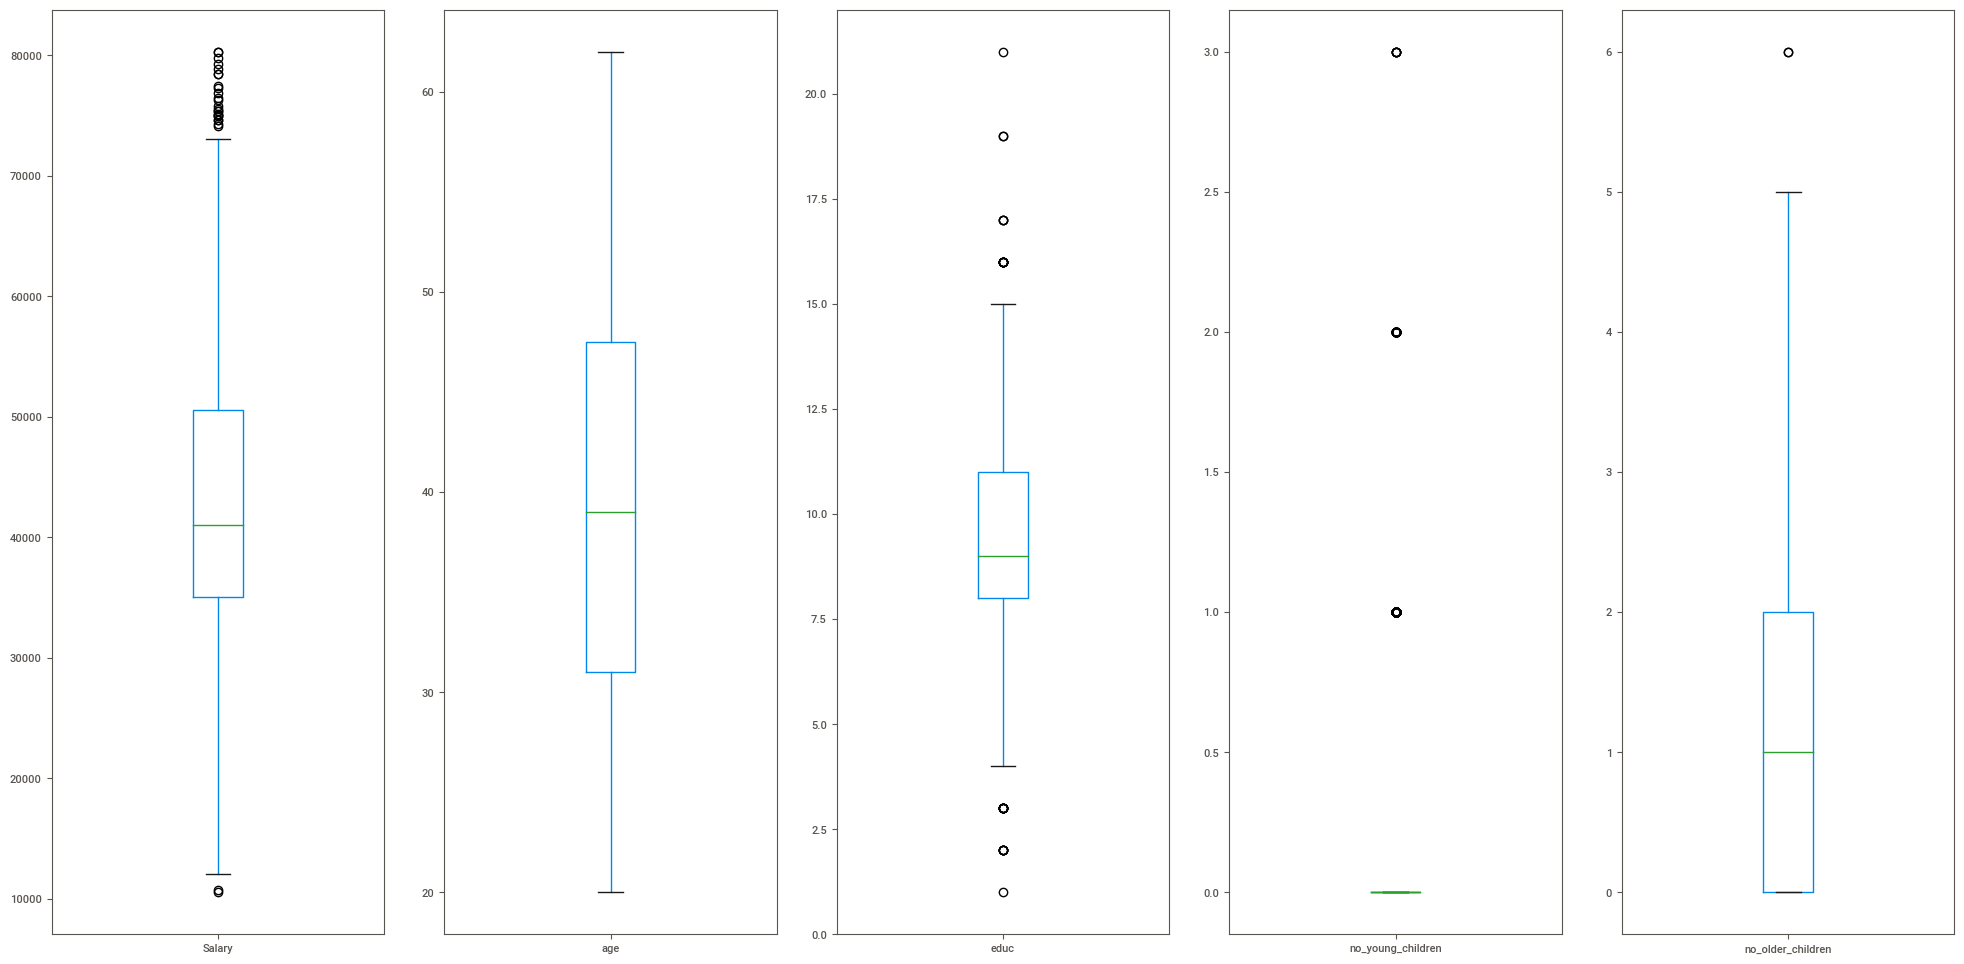

In [50]:
data_df.plot(kind='box',subplots=True,figsize=(20,10))
plt.tight_layout(pad=2.0)

In [51]:
print('no_young_children')
data_df['no_young_children'].value_counts()

no_young_children


0    617
1    141
2     52
3      5
Name: no_young_children, dtype: int64

In [52]:
for column in data_df.columns:
    if data_df[column].dtype == 'object':
        print(column.upper(),': ',data_df[column].nunique())
        print(data_df[column].value_counts().sort_values())
        print('\n')

HOLLIDAY_PACKAGE :  2
yes    389
no     426
Name: Holliday_Package, dtype: int64


FOREIGN :  2
yes    211
no     604
Name: foreign, dtype: int64




In [53]:
holiday_packages=sv.compare_intra(data_df, data_df["Holliday_Package"] == "yes", ["yes", "no"])

In [54]:
holiday_packagesreport=holiday_packages.show_html('holiday_packagesreport.html')
holiday_packagesreport

Report holiday_packagesreport.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


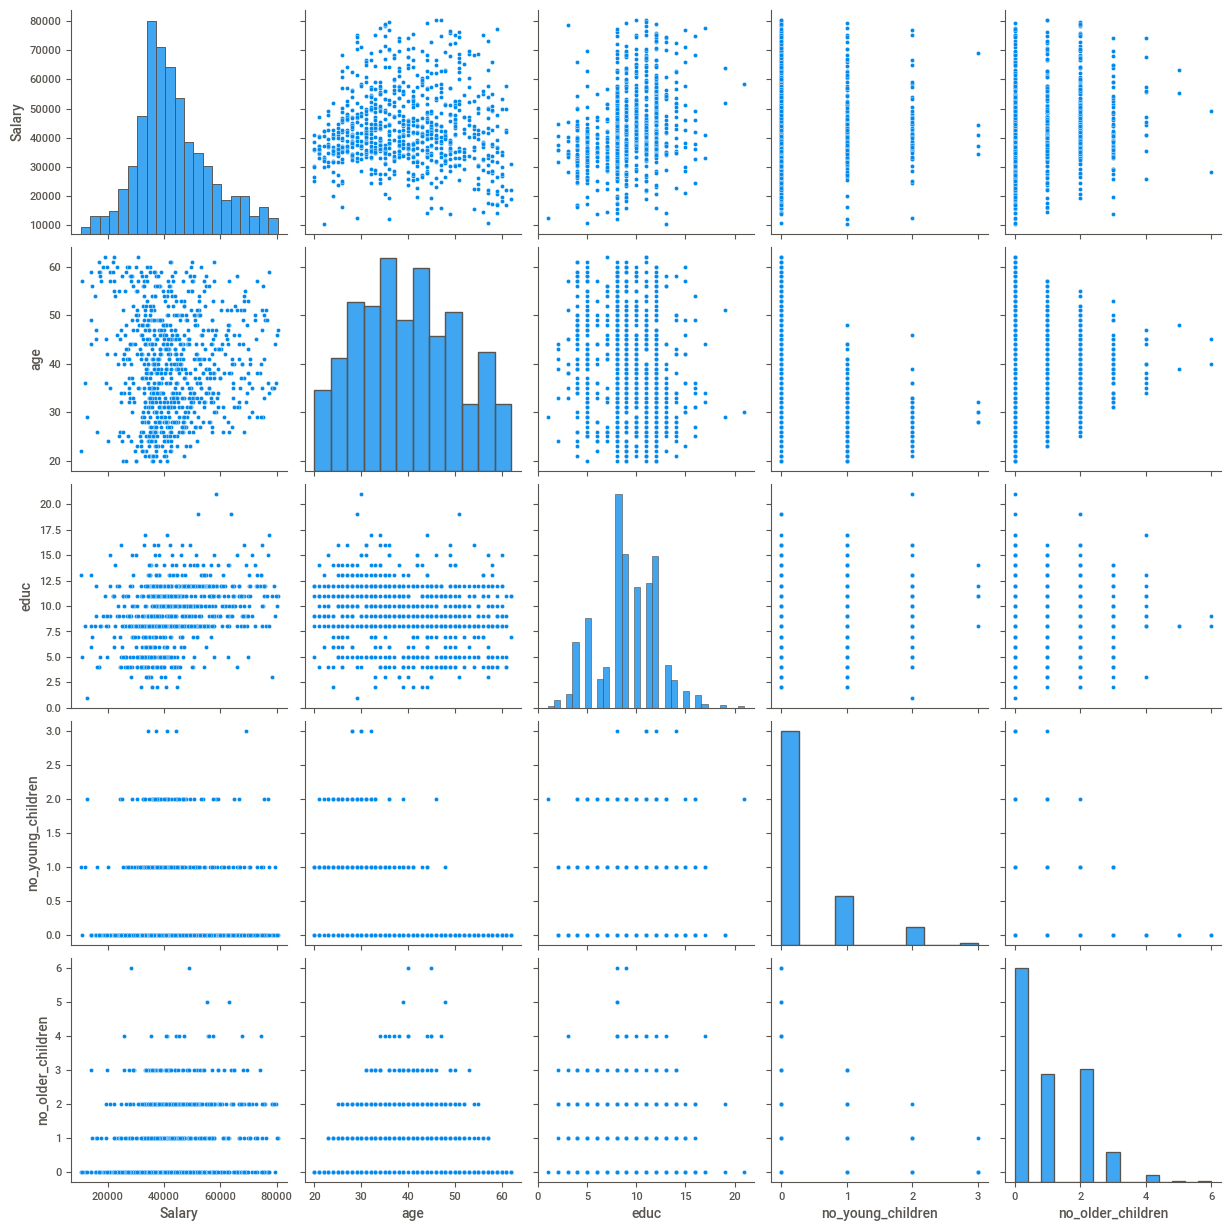

In [55]:
sns.pairplot(data_df)

#### 2.2 Do not scale the data. Encode the data (having string values) for Modelling. Data Split: Split the data into train and test (70:30). Apply Logistic Regression and LDA (linear discriminant analysis).

In [56]:
data_df['foreign']=np.where(data_df['foreign'] =='yes', '1', data_df['foreign'])
data_df['foreign']=np.where(data_df['foreign'] =='no', '0', data_df['foreign'])

In [57]:
data_df.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,no,48412,30,8,1,1,0
1,yes,37207,45,8,0,1,0
2,no,58022,46,9,0,0,0
3,no,66503,31,11,2,0,0
4,no,66734,44,12,0,2,0


In [58]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815 entries, 0 to 871
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Holliday_Package   815 non-null    object
 1   Salary             815 non-null    int64 
 2   age                815 non-null    int64 
 3   educ               815 non-null    int64 
 4   no_young_children  815 non-null    int64 
 5   no_older_children  815 non-null    int64 
 6   foreign            815 non-null    object
dtypes: int64(5), object(2)
memory usage: 50.9+ KB


In [59]:
X = np.asmatrix(data_df[['Salary','age','educ','no_young_children','no_older_children','foreign']])
Y = np.asarray(data_df['Holliday_Package'])
test_size = 0.30 # taking 70:30 training and test set
seed = 1  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
type(X_train)

numpy.matrix

In [60]:
#logistic regression 

lgmodel = LogisticRegression(solver='liblinear')
lgmodel=lgmodel.fit(X_train, y_train)
lgmodel

LogisticRegression(solver='liblinear')

In [61]:
train_pred_lg=lgmodel.predict(X_train)
test_pred_lg =lgmodel.predict(X_test)

In [62]:
modeldf=data_df.copy()
modeldf['predict_log_class']=lgmodel.predict(X)

In [63]:
#lDA
clf = LinearDiscriminantAnalysis()
ldamodel=clf.fit(X_train, y_train)
ldamodel

LinearDiscriminantAnalysis()

In [64]:
train_pred_lda=ldamodel.predict(X_train)
test_pred_lda =ldamodel.predict(X_test)

In [65]:
modeldf['predict_LDA_class']=ldamodel.predict(X)

#### 2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model Final Model: Compare Both the models and write inference which model is best/optimized.

#### Logistic Regression

In [66]:
print("Accuracy score  for Logistic regression train variables ")
lgmodel_train_score = lgmodel.score(X_train, y_train)
print (lgmodel_train_score)

Accuracy score  for Logistic regression train variables 
0.6508771929824562


In [67]:
print("Accuracy score for Logistic regression test variables ")
lgmodel_test_score = lgmodel.score(X_test, y_test)
lgmodel_test_score

Accuracy score for Logistic regression test variables 


0.6204081632653061

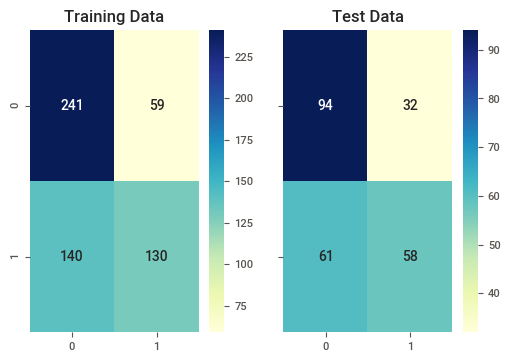

In [68]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap(metrics.confusion_matrix(y_train, train_pred_lg),annot=True,fmt='.5g',cmap='YlGnBu',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap(metrics.confusion_matrix(y_test, test_pred_lg),annot=True,fmt='.5g',cmap='YlGnBu',ax=a[0][1]);
a[0][1].set_title('Test Data');

In [69]:
print("Logistic regression Classfication report  ")

print('Classification Report of the training data:\n\n',metrics.classification_report(y_train,train_pred_lg),'\n')
print('Classification Report of the test data:\n\n',metrics.classification_report(y_test, test_pred_lg),'\n')

Logistic regression Classfication report  
Classification Report of the training data:

               precision    recall  f1-score   support

          no       0.63      0.80      0.71       300
         yes       0.69      0.48      0.57       270

    accuracy                           0.65       570
   macro avg       0.66      0.64      0.64       570
weighted avg       0.66      0.65      0.64       570
 

Classification Report of the test data:

               precision    recall  f1-score   support

          no       0.61      0.75      0.67       126
         yes       0.64      0.49      0.56       119

    accuracy                           0.62       245
   macro avg       0.63      0.62      0.61       245
weighted avg       0.62      0.62      0.61       245
 



AUC and ROC FOR Logistic regression
AUC for the Training Data: 0.738
AUC for the Test Data: 0.665


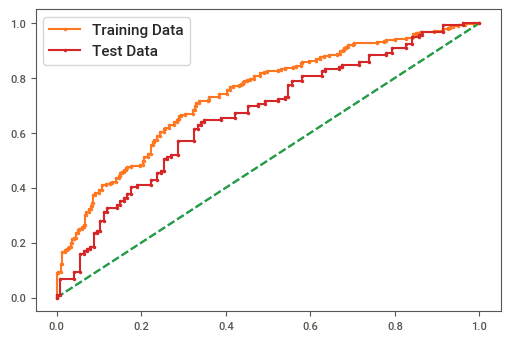

In [70]:
print("AUC and ROC FOR Logistic regression")
lg_pred_prob_train = lgmodel.predict_proba(X_train)
lg_pred_prob_test = lgmodel.predict_proba(X_test)

# AUC and ROC for the training data

# calculate AUC
lg_train_auc = metrics.roc_auc_score(y_train,lg_pred_prob_train[:,1])
print('AUC for the Training Data: %.3f' % lg_train_auc)

#  calculate roc curve
lg_train_fpr, lg_train_tpr, thresholds = metrics.roc_curve(y_train,lg_pred_prob_train[:,1],pos_label='yes')
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(lg_train_fpr, lg_train_tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data

# calculate AUC
lg_test_auc = metrics.roc_auc_score(y_test,lg_pred_prob_test[:,1])
print('AUC for the Test Data: %.3f' % lg_test_auc)

#  calculate roc curve
lg_test_fpr,lg_test_tpr, thresholds = metrics.roc_curve(y_test,lg_pred_prob_test[:,1],pos_label='yes')
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(lg_test_fpr, lg_test_tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.show()

#### LDA

In [71]:
print("Accuracy score  for LDA  train variables ")
ldamodel_train_score = ldamodel.score(X_train, y_train)
print (ldamodel_train_score)

Accuracy score  for LDA  train variables 
0.6754385964912281


In [72]:
print("Accuracy score for LDA test variables ")
ldamodel_test_score = ldamodel.score(X_test, y_test)
ldamodel_test_score

Accuracy score for LDA test variables 


0.6204081632653061

 confusion matrix Train variables for LDA 


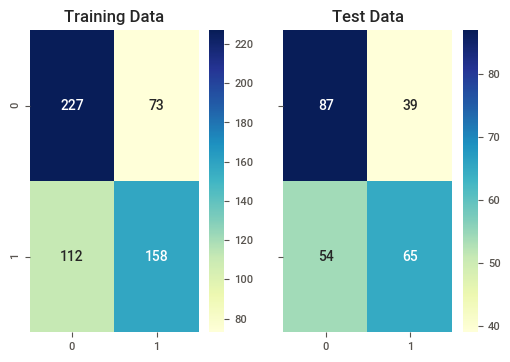

In [73]:
print(" confusion matrix Train variables for LDA ")
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train, train_pred_lda)),annot=True,fmt='.5g',cmap='YlGnBu',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test, test_pred_lda)),annot=True,fmt='.5g',cmap='YlGnBu',ax=a[0][1]);
a[0][1].set_title('Test Data');

In [74]:
print("LDA Classfication report  ")

print('Classification Report of the training data:\n\n',metrics.classification_report(y_train,train_pred_lda),'\n')
print('Classification Report of the test data:\n\n',metrics.classification_report(y_test, test_pred_lda),'\n')

LDA Classfication report  
Classification Report of the training data:

               precision    recall  f1-score   support

          no       0.67      0.76      0.71       300
         yes       0.68      0.59      0.63       270

    accuracy                           0.68       570
   macro avg       0.68      0.67      0.67       570
weighted avg       0.68      0.68      0.67       570
 

Classification Report of the test data:

               precision    recall  f1-score   support

          no       0.62      0.69      0.65       126
         yes       0.62      0.55      0.58       119

    accuracy                           0.62       245
   macro avg       0.62      0.62      0.62       245
weighted avg       0.62      0.62      0.62       245
 



AUC and ROC FOR LDA
AUC for the Training Data: 0.743
AUC for the Test Data: 0.670


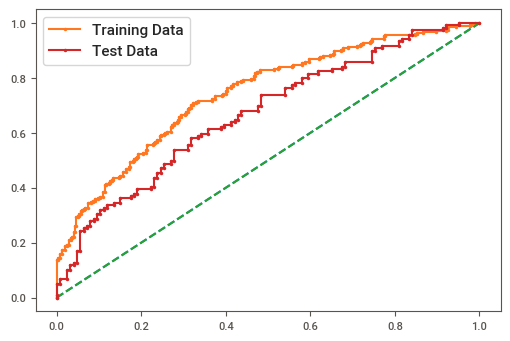

In [75]:
print("AUC and ROC FOR LDA")
lda_pred_prob_train = ldamodel.predict_proba(X_train)
lda_pred_prob_test = ldamodel.predict_proba(X_test)

# AUC and ROC for the training data

# calculate AUC
lda_train_auc = metrics.roc_auc_score(y_train,lda_pred_prob_train[:,1])
print('AUC for the Training Data: %.3f' % lda_train_auc)

#  calculate roc curve
lda_train_fpr, lda_train_tpr, thresholds = metrics.roc_curve(y_train,lda_pred_prob_train[:,1],pos_label='yes')
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(lda_train_fpr, lda_train_tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data

# calculate AUC
lda_test_auc = metrics.roc_auc_score(y_test,lda_pred_prob_test[:,1])
print('AUC for the Test Data: %.3f' % lda_test_auc)

#  calculate roc curve
lda_test_fpr, lda_test_tpr, thresholds = metrics.roc_curve(y_test,lda_pred_prob_test[:,1],pos_label='yes')
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(lda_test_fpr, lda_test_tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.show()

#### Compare both models

In [76]:
cmetrics=classification_report(y_train,train_pred_lg,output_dict=True)
df=pd.DataFrame(cmetrics).transpose()
lg_train_f1=round(df.loc["yes"][2],2)
lg_train_recall=round(df.loc["yes"][1],2)
lg_train_precision=round(df.loc["yes"][0],2)
df

,precision,recall,f1-score,support
no,0.632546,0.803333,0.707783,300.000000
yes,0.687831,0.481481,0.566449,270.000000
accuracy,0.650877,0.650877,0.650877,0.650877
macro avg,0.660188,0.642407,0.637116,570.000000
weighted avg,0.658733,0.650877,0.640835,570.000000


In [77]:
cmetrics=classification_report(y_test,test_pred_lg,output_dict=True)
df=pd.DataFrame(cmetrics).transpose()
lg_test_f1=round(df.loc["yes"][2],2)
lg_test_recall=round(df.loc["yes"][1],2)
lg_test_precision=round(df.loc["yes"][0],2)
df

,precision,recall,f1-score,support
no,0.606452,0.746032,0.669039,126.000000
yes,0.644444,0.487395,0.555024,119.000000
accuracy,0.620408,0.620408,0.620408,0.620408
macro avg,0.625448,0.616713,0.612032,245.000000
weighted avg,0.624905,0.620408,0.613660,245.000000


In [78]:
cmetrics=classification_report(y_train,train_pred_lda,output_dict=True)
df=pd.DataFrame(cmetrics).transpose()
lda_train_f1=round(df.loc["yes"][2],2)
lda_train_recall=round(df.loc["yes"][1],2)
lda_train_precision=round(df.loc["yes"][0],2)
df

,precision,recall,f1-score,support
no,0.669617,0.756667,0.710485,300.000000
yes,0.683983,0.585185,0.630739,270.000000
accuracy,0.675439,0.675439,0.675439,0.675439
macro avg,0.676800,0.670926,0.670612,570.000000
weighted avg,0.676422,0.675439,0.672710,570.000000


In [79]:
cmetrics=classification_report(y_test,test_pred_lda,output_dict=True)
df=pd.DataFrame(cmetrics).transpose()
lda_test_f1=round(df.loc["yes"][2],2)
lda_test_recall=round(df.loc["yes"][1],2)
lda_test_precision=round(df.loc["yes"][0],2)
df

,precision,recall,f1-score,support
no,0.617021,0.690476,0.651685,126.000000
yes,0.625000,0.546218,0.582960,119.000000
accuracy,0.620408,0.620408,0.620408,0.620408
macro avg,0.621011,0.618347,0.617323,245.000000
weighted avg,0.620897,0.620408,0.618304,245.000000


In [80]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'Logistic reg Train':[lgmodel_train_score,lg_train_auc,lg_train_recall,lg_train_precision,lg_train_f1],
        'Logistic reg Test':[lgmodel_test_score,lg_test_auc,lg_test_recall,lg_test_precision,lg_test_f1],
        'LDA Train':[ldamodel_train_score,lda_train_auc,lda_train_recall,lda_train_precision,lda_train_f1],
        'LDA Test':[ldamodel_test_score,lda_test_auc,lda_test_recall,lda_test_precision,lda_test_f1]},index=index)
round(data,2)

,Logistic reg Train,Logistic reg Test,LDA Train,LDA Test
Accuracy,0.65,0.62,0.68,0.62
AUC,0.74,0.67,0.74,0.67
Recall,0.48,0.49,0.59,0.55
Precision,0.69,0.64,0.68,0.62
F1 Score,0.57,0.56,0.63,0.58


ROC curve for Train data 


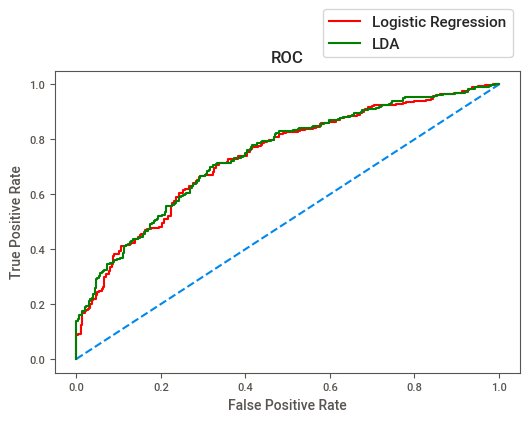

In [81]:
print("ROC curve for Train data ")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(lg_train_fpr, lg_train_tpr,color='red',label="Logistic Regression")
plt.plot(lda_train_fpr,lda_train_tpr,color='green',label="LDA")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

ROC curve for Test data


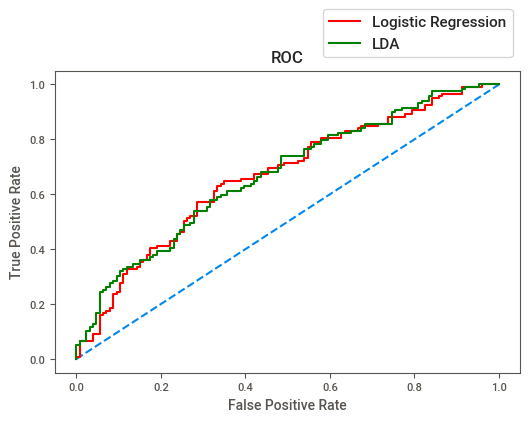

In [82]:
print("ROC curve for Test data")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(lg_test_fpr, lg_test_tpr,color='red',label="Logistic Regression")
plt.plot(lda_test_fpr,lda_test_tpr,color='green',label="LDA")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')